In [ ]:
!pip install pytorch-lightning

In [ ]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pytorch_lightning as pl

In [ ]:
torch.manual_seed(200)
np.random.seed(200)

# set pandas to better show our data
pd.set_option('display.max_columns', None)
pd.set_option('expand_frame_repr', False)

In [ ]:
df=pd.read_csv("/content/electricityConsumptionAndProductioction.csv.zip")
df

,DateTime,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
0,2019-01-01 00:00:00,6352,6527,1395,79,1383,1896,1744,0,30
1,2019-01-01 01:00:00,6116,5701,1393,96,1112,1429,1641,0,30
2,2019-01-01 02:00:00,5873,5676,1393,142,1030,1465,1616,0,30
3,2019-01-01 03:00:00,5682,5603,1397,191,972,1455,1558,0,30
4,2019-01-01 04:00:00,5557,5454,1393,159,960,1454,1458,0,30
...,...,...,...,...,...,...,...,...,...,...
36767,2023-03-12 19:00:00,6500,6643,1407,111,3084,933,1047,0,60
36768,2023-03-12 20:00:00,6471,6484,1408,58,2983,933,1042,0,60
36769,2023-03-12 21:00:00,6194,6413,1406,39,2938,935,1031,0,62
36770,2023-03-12 22:00:00,5708,6217,1406,8,2823,917,1001,0,61


Preprocessing

In [ ]:
df.drop(["Production", "Nuclear", "Wind", "Hydroelectric", "Oil and Gas", "Coal", "Solar", "Biomass"], axis=1, inplace=True)
df

,DateTime,Consumption
0,2019-01-01 00:00:00,6352
1,2019-01-01 01:00:00,6116
2,2019-01-01 02:00:00,5873
3,2019-01-01 03:00:00,5682
4,2019-01-01 04:00:00,5557
...,...,...
36767,2023-03-12 19:00:00,6500
36768,2023-03-12 20:00:00,6471
36769,2023-03-12 21:00:00,6194
36770,2023-03-12 22:00:00,5708


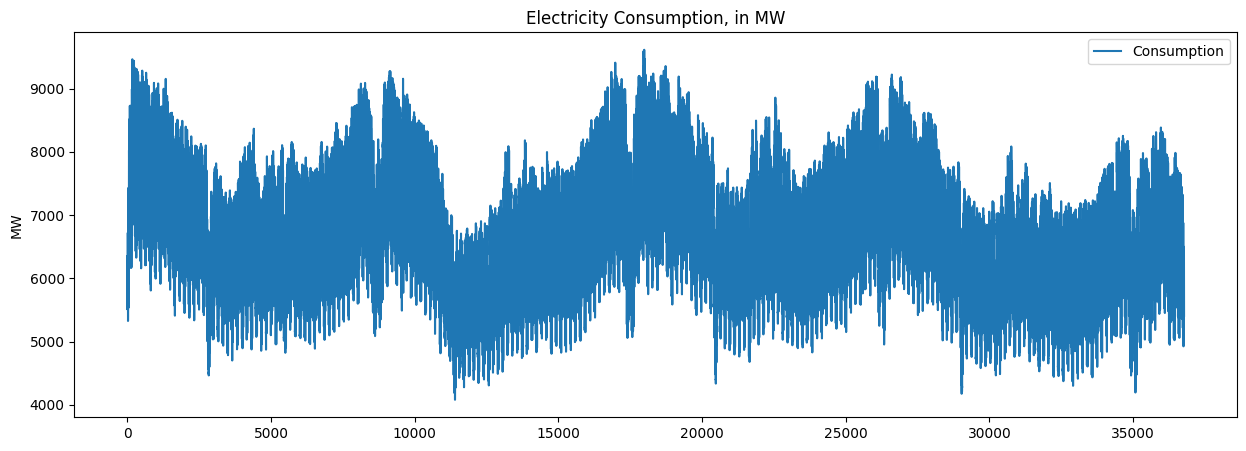

In [ ]:
df[["Consumption"]].plot(style="-", figsize=(15, 5), title="Electricity Consumption, in MW")
plt.ylabel('MW')
plt.show()

Sequencing the data

In [ ]:
sequenceSize = 8

# let's compute a cutoff index that will separate the training and the test data
testCutOffIndex = int(len(df) * 0.9)

# also we should keep test date times in order to later do some nice plotting
testDates = df[testCutOffIndex + sequenceSize: len(df)]["DateTime"]

df = df["Consumption"]

train = df[0: testCutOffIndex]
test = df[testCutOffIndex:]

# the scaler wants a bi dimensional array [[1], [2], [3]], insstead of [1, 2, 3]
train = train.to_numpy().reshape(-1, 1)
test = test.to_numpy().reshape(-1, 1)

In [ ]:
# in order for our neural network to work better we should scale the values
scaler = StandardScaler()
train = scaler.fit_transform(train).flatten().tolist()
test = scaler.transform(test).flatten().tolist()

In [ ]:
def toSequence(data, sequenceSize):
    X = []
    y = []

    for i in range(len(data) - sequenceSize):
        window = data[i: (i + sequenceSize)]
        target = data[i + sequenceSize]

        X.append(window)
        y.append(target)

    return torch.tensor(X, dtype=torch.float32).reshape(-1, sequenceSize, 1), torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

In [ ]:
xTrain, yTrain = toSequence(train, sequenceSize)
xTest, yTest = toSequence(test, sequenceSize)

Creating LSTM

In [ ]:
class ElectricityLstm(pl.LightningModule):
    def __init__(self):
        super(ElectricityLstm, self).__init__()

        self.lossFunction = nn.MSELoss()

        self.lstm = nn.LSTM(input_size=1, hidden_size=32, batch_first=True)
        self.droput = nn.Dropout(0.2)

        self.fc1 = nn.Linear(in_features=32, out_features=16)
        self.fc2 = nn.Linear(in_features=16, out_features=1)

    def forward(self, X):
        out, _ = self.lstm(X)
        out = out[:, -1, :]
        out = self.droput(out)
        out = self.fc1(out)
        out = self.fc2(out)

        return out


    def training_step(self, batch, batchIndex):
        X, y = batch
        out = self(X)
        loss = self.lossFunction(out, y)

        return {"loss": loss}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0002)

Traning the model

In [ ]:
train_dataset = TensorDataset(xTrain, yTrain)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = TensorDataset(xTest, yTest)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
numberOfEpochs = 5

model = ElectricityLstm()

trainer = pl.Trainer(max_epochs = numberOfEpochs)

model.train()

trainer.fit(model, train_loader)

model.eval()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type    | Params
-----------------------------------------
0 | lossFunction | MSELoss | 0     
1 | lstm         | LSTM    | 4.5 K 
2 | droput       | Dropout | 0     
3 | fc1          | Linear  | 528   
4 | fc2          | Linear  | 17    
-----------------------------------------
5.0 K     Trainable params
0         Non-trainable params
5.0 K     Total params
0.020     Total estimated model params size (MB)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the va

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


ElectricityLstm(
  (lossFunction): MSELoss()
  (lstm): LSTM(1, 32, batch_first=True)
  (droput): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=32, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
)

Calculating loss

In [ ]:
predictions = []
actualLabels = []

for batch in test_loader:
    X, y = batch
    prediction = model(X)

    predictions.extend(prediction.detach().numpy().flatten())
    actualLabels.extend(y.detach().numpy().flatten())

In [ ]:
scaledPredictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
scaledYTest = scaler.inverse_transform(np.array(actualLabels).reshape(-1, 1))

In [ ]:
averageLoss = np.sqrt(np.mean((scaledPredictions - scaledYTest) ** 2))
print(f"averageLoss: {averageLoss}")

averageLoss: 164.46144104003906


Prediction

(array([  0,  40,  80, 120, 160]),
 [Text(0, 0, '2022-10-11 04:00:00'),
  Text(40, 0, '2022-10-12 20:00:00'),
  Text(80, 0, '2022-10-14 12:00:00'),
  Text(120, 0, '2022-10-16 04:00:00'),
  Text(160, 0, '2022-10-17 20:00:00')])

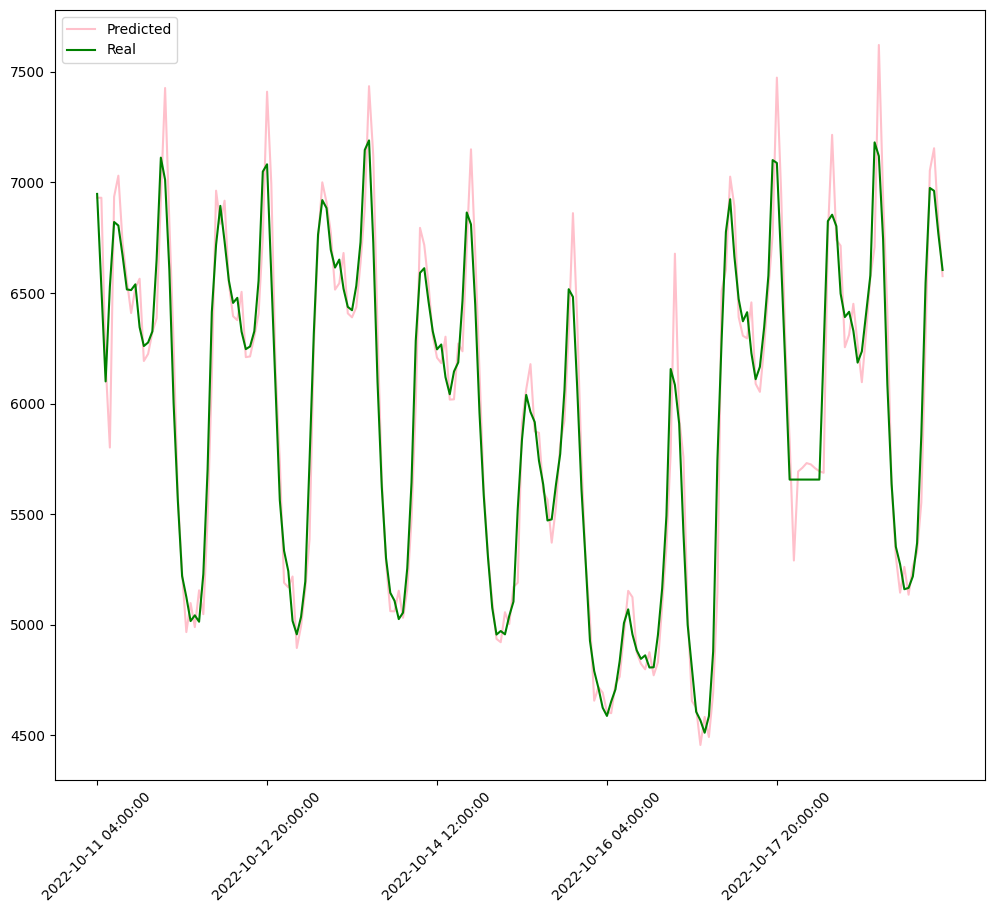

In [ ]:
dataSetSize = 200

plt.figure(figsize=(12,10))
plt.plot(testDates[:dataSetSize], scaledPredictions[:dataSetSize], color= "pink")
plt.plot(testDates[:dataSetSize], scaledYTest[:dataSetSize], color= "green")
plt.legend(["Predicted", "Real"])
plt.xticks(np.arange(0, dataSetSize, round((dataSetSize / 5)/10)*10))
plt.xticks(rotation=45)